# Emotion Detection

In [2]:
import pandas as pd
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os

# adding all the path for each folder into a dataframe and assign her target
list_path = ['angry/','disgusted/', 'fearful/', 'happy/', 'neutral/', 'sad/', 'surprised/']
PATH = './train/'

data = pd.DataFrame()

for i in range(len(list_path)):
    
    all_path = PATH + list_path[i]
    create_data = pd.DataFrame(os.listdir(path = all_path), columns = ['filenames'])
    create_data.filenames = create_data.filenames.apply(lambda x : all_path + x)
    create_data['target'] = i
    
    data = pd.concat([data, create_data])
    
    create_data = pd.DataFrame()
    
data.head()

2024-10-15 21:29:26.794091: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,filenames,target
0,./train/angry/im2072.png,0
1,./train/angry/im771.png,0
2,./train/angry/im2714.png,0
3,./train/angry/im2700.png,0
4,./train/angry/im765.png,0


In [3]:
final_data = pd.DataFrame()

# keep only 2000 of each target 
for i in range(len(list_path)):
    frac_data = data[data.target == i][: 2000]
    final_data = pd.concat([final_data, frac_data])
    frac_data = pd.DataFrame()
    
# suffle data randomly    
final_data = final_data.sample(frac = 1).reset_index(drop = True)
final_data.head()

,filenames,target
0,./train/disgusted/im367.png,1
1,./train/happy/im3179.png,3
2,./train/fearful/im4059.png,2
3,./train/angry/im3287.png,0
4,./train/happy/im238.png,3


In [4]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12436 entries, 0 to 12435
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filenames  12436 non-null  object
 1   target     12436 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 194.4+ KB


The emotion of the Image: fearful/
Image shape: (48, 48)


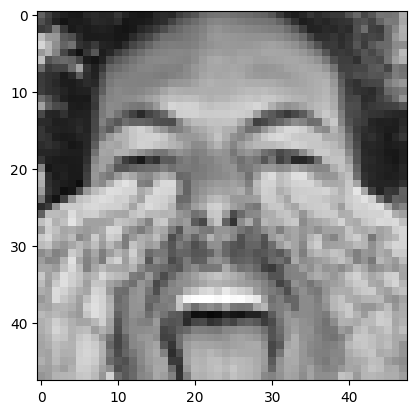

In [5]:
from tensorflow.keras.utils import load_img
import random

# random idx
idx = random.choice(list(np.arange(0, len(final_data) + 1, 1)))

img = load_img(final_data.filenames[idx])
target = final_data.target[idx]
print(f'The emotion of the Image: {list_path[target]}')
print(f'Image shape: {plt.imread(final_data.filenames[idx]).shape}')
plt.imshow(img)
plt.show()


In [6]:
# shape of all images
all_shape = [plt.imread(final_data.filenames[i]).shape for i in range(len(final_data))]
print(f'Shape: {set(all_shape)}')

Shape: {(48, 48)}


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rescale = 1. / 255, validation_split = 0.2, horizontal_flip = True)
final_data['target'] = final_data['target'].astype(str)
generator

In [8]:
train_generator = generator.flow_from_dataframe(dataframe = final_data, 
                                 x_col = 'filenames', 
                                 y_col = 'target', 
                                 class_mode = 'categorical',
                                 batche_size = 1, 
                                 shuffle = True, 
                                 target_size = (48, 48),
                                 color_mode = 'grayscale', 
                                 subset = 'training')

validation_generator = generator.flow_from_dataframe(dataframe = final_data, 
                                 x_col = 'filenames', 
                                 y_col = 'target', 
                                 class_mode = 'categorical',
                                 batche_size = 1, 
                                 target_size = (48, 48),
                                 color_mode = 'grayscale', 
                                 subset = 'validation')

type(train_generator)

Found 9949 validated image filenames belonging to 7 classes.
Found 2487 validated image filenames belonging to 7 classes.


keras.src.legacy.preprocessing.image.DataFrameIterator

In [9]:
img, label = next(train_generator)
img.shape # (32, 256, 256, 3)

(32, 48, 48, 1)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, BatchNormalization, ReLU, LeakyReLU, MaxPool2D, Flatten


model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (48, 48, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(filters = 128, kernel_size = (3, 3)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.35))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = len(list_path), activation = 'softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,783 (624.15 KB)

 Trainable params: 159,335 (622.40 KB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(), 
              metrics = ['accuracy']) 

# ReduceLROnPlateau
callback_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.15, patience = 5, min_lr = 0.001)

# Early Stopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

history = model.fit(x = train_generator, 
                    validation_data = validation_generator, 
                    epochs = 30, 
                    callbacks =  callback_reduce,
                    verbose = 1)

Epoch 1/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 60s 177ms/step - accuracy: 0.2235 - loss: 1.8967 - val_accuracy: 0.2216 - val_loss: 1.9518 - learning_rate: 0.0010
Epoch 2/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 57s 183ms/step - accuracy: 0.3581 - loss: 1.6296 - val_accuracy: 0.2646 - val_loss: 1.8259 - learning_rate: 0.0010
Epoch 3/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 61s 197ms/step - accuracy: 0.3862 - loss: 1.5445 - val_accuracy: 0.3808 - val_loss: 1.5651 - learning_rate: 0.0010
Epoch 4/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 60s 191ms/step - accuracy: 0.3996 - loss: 1.5152 - val_accuracy: 0.3615 - val_loss: 1.6444 - learning_rate: 0.0010
Epoch 5/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 56s 178ms/step - accuracy: 0.4266 - loss: 1.4673 - val_accuracy: 0.3715 - val_loss: 1.5891 - learning_rate: 0.0010
Epoch 6/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 552s 2s/step - accuracy: 0.4543 - loss: 1.4071 - val_accuracy: 0.4415 - val_loss: 1.4644 - learning_rate: 0.0010
Epoch 7/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 1366s 4s/step - accuracy: 0.4728

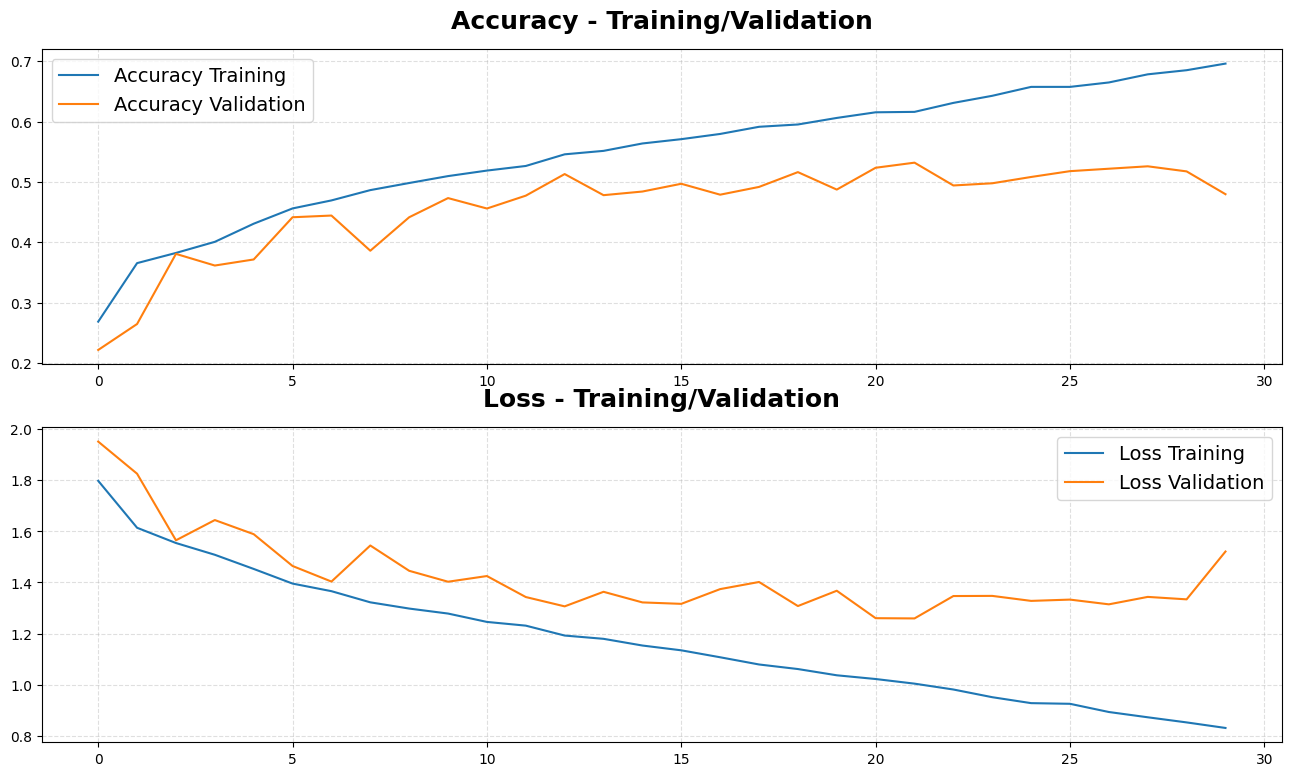

In [16]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
loss = history.history['loss']
loss_val = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (16, 9))
ax1.plot(history.epoch, acc, label = 'Accuracy Training')
ax1.plot(history.epoch, acc_val, label = 'Accuracy Validation')
ax1.set_title('Accuracy - Training/Validation', fontsize = 18, fontweight = 'bold', y = 1.04)
ax1.legend(fontsize = 14)
ax1.grid(True, ls = '--', alpha = 0.4)

ax2.plot(history.epoch, loss, label = 'Loss Training')
ax2.plot(history.epoch, loss_val, label = 'Loss Validation')
ax2.set_title('Loss - Training/Validation', fontsize = 18, fontweight = 'bold', y = 1.04)
ax2.legend(fontsize = 14)
ax2.grid(True, ls = '--', alpha = 0.4)
#ax2.vline(x = 7)
plt.show()
#plt.savefig('second_model.png')

# Testing On New Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


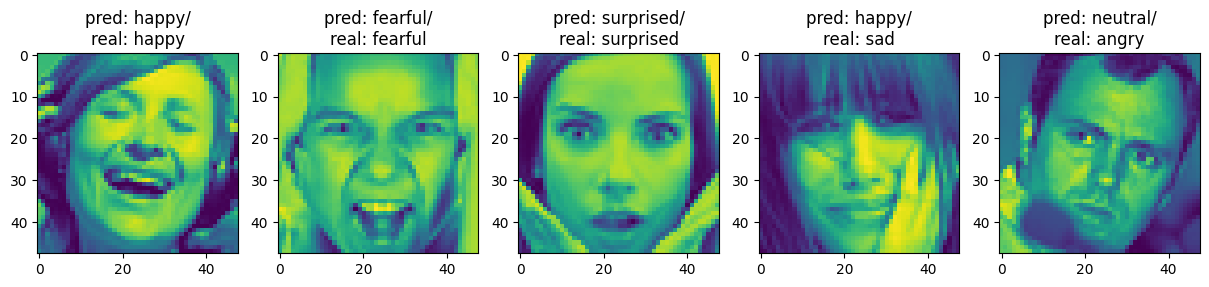

In [20]:
import numpy as np
import os
import matplotlib.pyplot as plt

list_path_test = ['./test/angry/', './test/disgusted/', './test/fearful/', './test/happy/', './test/neutral/', './test/sad/',
                  './test/surprised/']

lst_path_plot = []
lst_prediction = []
real = []
for i in range(5):
    random_path = np.random.choice(list_path_test)  
    real.append(random_path)
      
    # Convertir les éléments en chaînes de caractères si nécessaire
    connection = [random_path + element.decode('utf-8') if isinstance(element, bytes) else element for element in os.listdir(random_path)]
    
    random_img = np.random.choice(connection)
    img_test = plt.imread(random_img)
    img_test_dim = img_test.reshape((48, 48, 1))
    img_test_dim = np.expand_dims(img_test_dim, axis=0)
    pred = model.predict(img_test_dim)
    
    lst_prediction.append(pred)
    lst_path_plot.append(random_img)


real = [real[i].replace('./test/', '') for i in range(5)]
real = [real[i].replace('/', '') for i in range(5)]

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, nrows=1, figsize=(15, 8))
ax1.imshow(plt.imread(lst_path_plot[0]))
ax1.set_title(f'pred: {list_path[np.argmax(lst_prediction[0])]}\nreal: {real[0]}')
ax2.imshow(plt.imread(lst_path_plot[1]))
ax2.set_title(f'pred: {list_path[np.argmax(lst_prediction[1])]}\nreal: {real[1]}')
ax3.imshow(plt.imread(lst_path_plot[2]))
ax3.set_title(f'pred: {list_path[np.argmax(lst_prediction[2])]}\nreal: {real[2]}')
ax4.imshow(plt.imread(lst_path_plot[3]))
ax4.set_title(f'pred: {list_path[np.argmax(lst_prediction[3])]}\nreal: {real[3]}')
ax5.imshow(plt.imread(lst_path_plot[4]))
ax5.set_title(f'pred: {list_path[np.argmax(lst_prediction[4])]}\nreal: {real[4]}')
plt.show()